# This notebook is meant to create functions for plotting 

Goal is then to add them to the classes or as checks that everything is well

In [1]:
%load_ext autoreload
%matplotlib inline

In [2]:
import os
import glob
import sys
import yaml

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tempest import casestudy
from tempest import grid
from tempest import joint_distrib
from tempest import handler

settings_path = 'settings/tropics.yaml'

In [3]:
# Instantiate CaseStudy by passing the settings. 
# Should also create appropriate directories
hdlr = handler.Handler(settings_path)
cs = casestudy.CaseStudy(hdlr, verbose = True)
gr = grid.Grid(hdlr, verbose = False, overwrite = False)
# jd = joint_distrib.JointDistribution(gr)


Found json file at {json_path}, loading it..
Data loaded from /homedata/mcarenso/tempest/DYAMOND_SAM_Tropics/var_id_days_i_t.json
LWNTA
day:      (#t)  t_i-t_f
16-08-01: (47) 1-47
16-08-02: (48) 48-95
16-08-03: (48) 96-143
16-08-04: (48) 144-191
16-08-05: (48) 192-239
16-08-06: (48) 240-287
16-08-07: (48) 288-335
16-08-08: (48) 336-383
16-08-09: (48) 384-431
16-08-10: (48) 432-479
16-08-11: (48) 480-527
16-08-12: (48) 528-575
16-08-13: (48) 576-623
16-08-14: (48) 624-671
16-08-15: (48) 672-719
16-08-16: (48) 720-767
16-08-17: (48) 768-815
16-08-18: (48) 816-863
16-08-19: (48) 864-911
16-08-20: (48) 912-959
16-08-21: (48) 960-1007
16-08-22: (48) 1008-1055
16-08-23: (48) 1056-1103
16-08-24: (48) 1104-1151
16-08-25: (48) 1152-1199
16-08-26: (48) 1200-1247
16-08-27: (48) 1248-1295
16-08-28: (48) 1296-1343
16-08-29: (48) 1344-1391
16-08-30: (48) 1392-1439
16-08-31: (48) 1440-1487
16-09-01: (48) 1488-1535
16-09-02: (48) 1536-1583
16-09-03: (48) 1584-1631
16-09-04: (48) 1632-1679
16-09-05: (4

In [4]:
jd = joint_distrib.JointDistribution(gr, nd=5, storm_tracking=True)

/data/fiolleau/DYAMOND/TOOCAN/TOOCAN_v2.07/GLOBAL/2016/FileTracking/TOOCAN-GLOBAL-20160901-20160910.dat.gz
/data/fiolleau/DYAMOND/TOOCAN/TOOCAN_v2.07/GLOBAL/2016/FileTracking/TOOCAN-GLOBAL-20160801-20160831.dat.gz


In [63]:
label = 353
storm = jd.storms[label]
lifecycle = storm.clusters

In [64]:
utc_0, utc_f = storm.Utime_Init, storm.Utime_End
i_0, i_f = hdlr.i_t_from_utc(utc_0)-1, hdlr.i_t_from_utc(utc_f)+1

print(utc_0, i_0)

17045.03 1490


In [65]:
import numpy as np

length = max(storm.latmax - storm.latmin, storm.lonmax - storm.lonmin)
bordersize = 5
i_t = i_0 + 5

# Use np.isclose to handle potential floating-point differences
if np.isclose(storm.latmax - storm.latmin, length):
    latmax, latmin = storm.latmax + bordersize, storm.latmin - bordersize
    lonmid = (storm.lonmin + storm.lonmax) / 2
    lonmax, lonmin = lonmid + bordersize + length / 2, lonmid - bordersize - length / 2
else : 
    latmid = (storm.lonmin + storm.lonmax) / 2
    latmax, latmin = storm.latmax + bordersize + length / 2, storm.latmin - bordersize - length / 2
    lonmax, lonmin = storm.lonmax + bordersize, storm.lonmin - bordersize 
print(lonmin, lonmax, latmin, latmax)
# Rest of your code
seg = hdlr.load_seg(i_t).sel(longitude=slice(lonmin, lonmax), latitude=slice(latmin, latmax))[0, :, :]
n_lat, n_lon = seg.shape
n = min(seg.shape)
seg = seg[n_lat//2 - n//2 : n_lat//2 + n//2 , n_lon//2 - n//2 : n_lon//2 + n//2]

171.05 181.99 -13.94 -2.2600000000000016


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'MCS_label' has multiple fill values {-999.0, -998.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [66]:
i = i_t - i_0 - 1 #weird because this exists only at i_0 + 1 since, at i_0 mcs ain't created
cm_lat, cm_lon = lifecycle.lat[i], lifecycle.lon[i]

var_ids = ["Prec", "PW", "T2mm", "Q2m"]
var_units = ["mm/h", "mm", "K", "?"]
var_cmaps = ["ocean_r", "Blues", "RdBu_r", "RdBu"]
vars = []
for var_id in var_ids:
    var = hdlr.load_var(gr, var_id, i_t)
    var = var.sel(lon=slice(lonmin, lonmax), lat=slice(latmin, latmax))[:, :] # approximate square
    var = var[n_lat//2 - n//2 : n_lat//2 + n//2 , n_lon//2 - n//2 : n_lon//2 + n//2] # exact square
    vars.append(var)
    print(f"{var_id} loaded ;", end ='\t')

KeyboardInterrupt: 

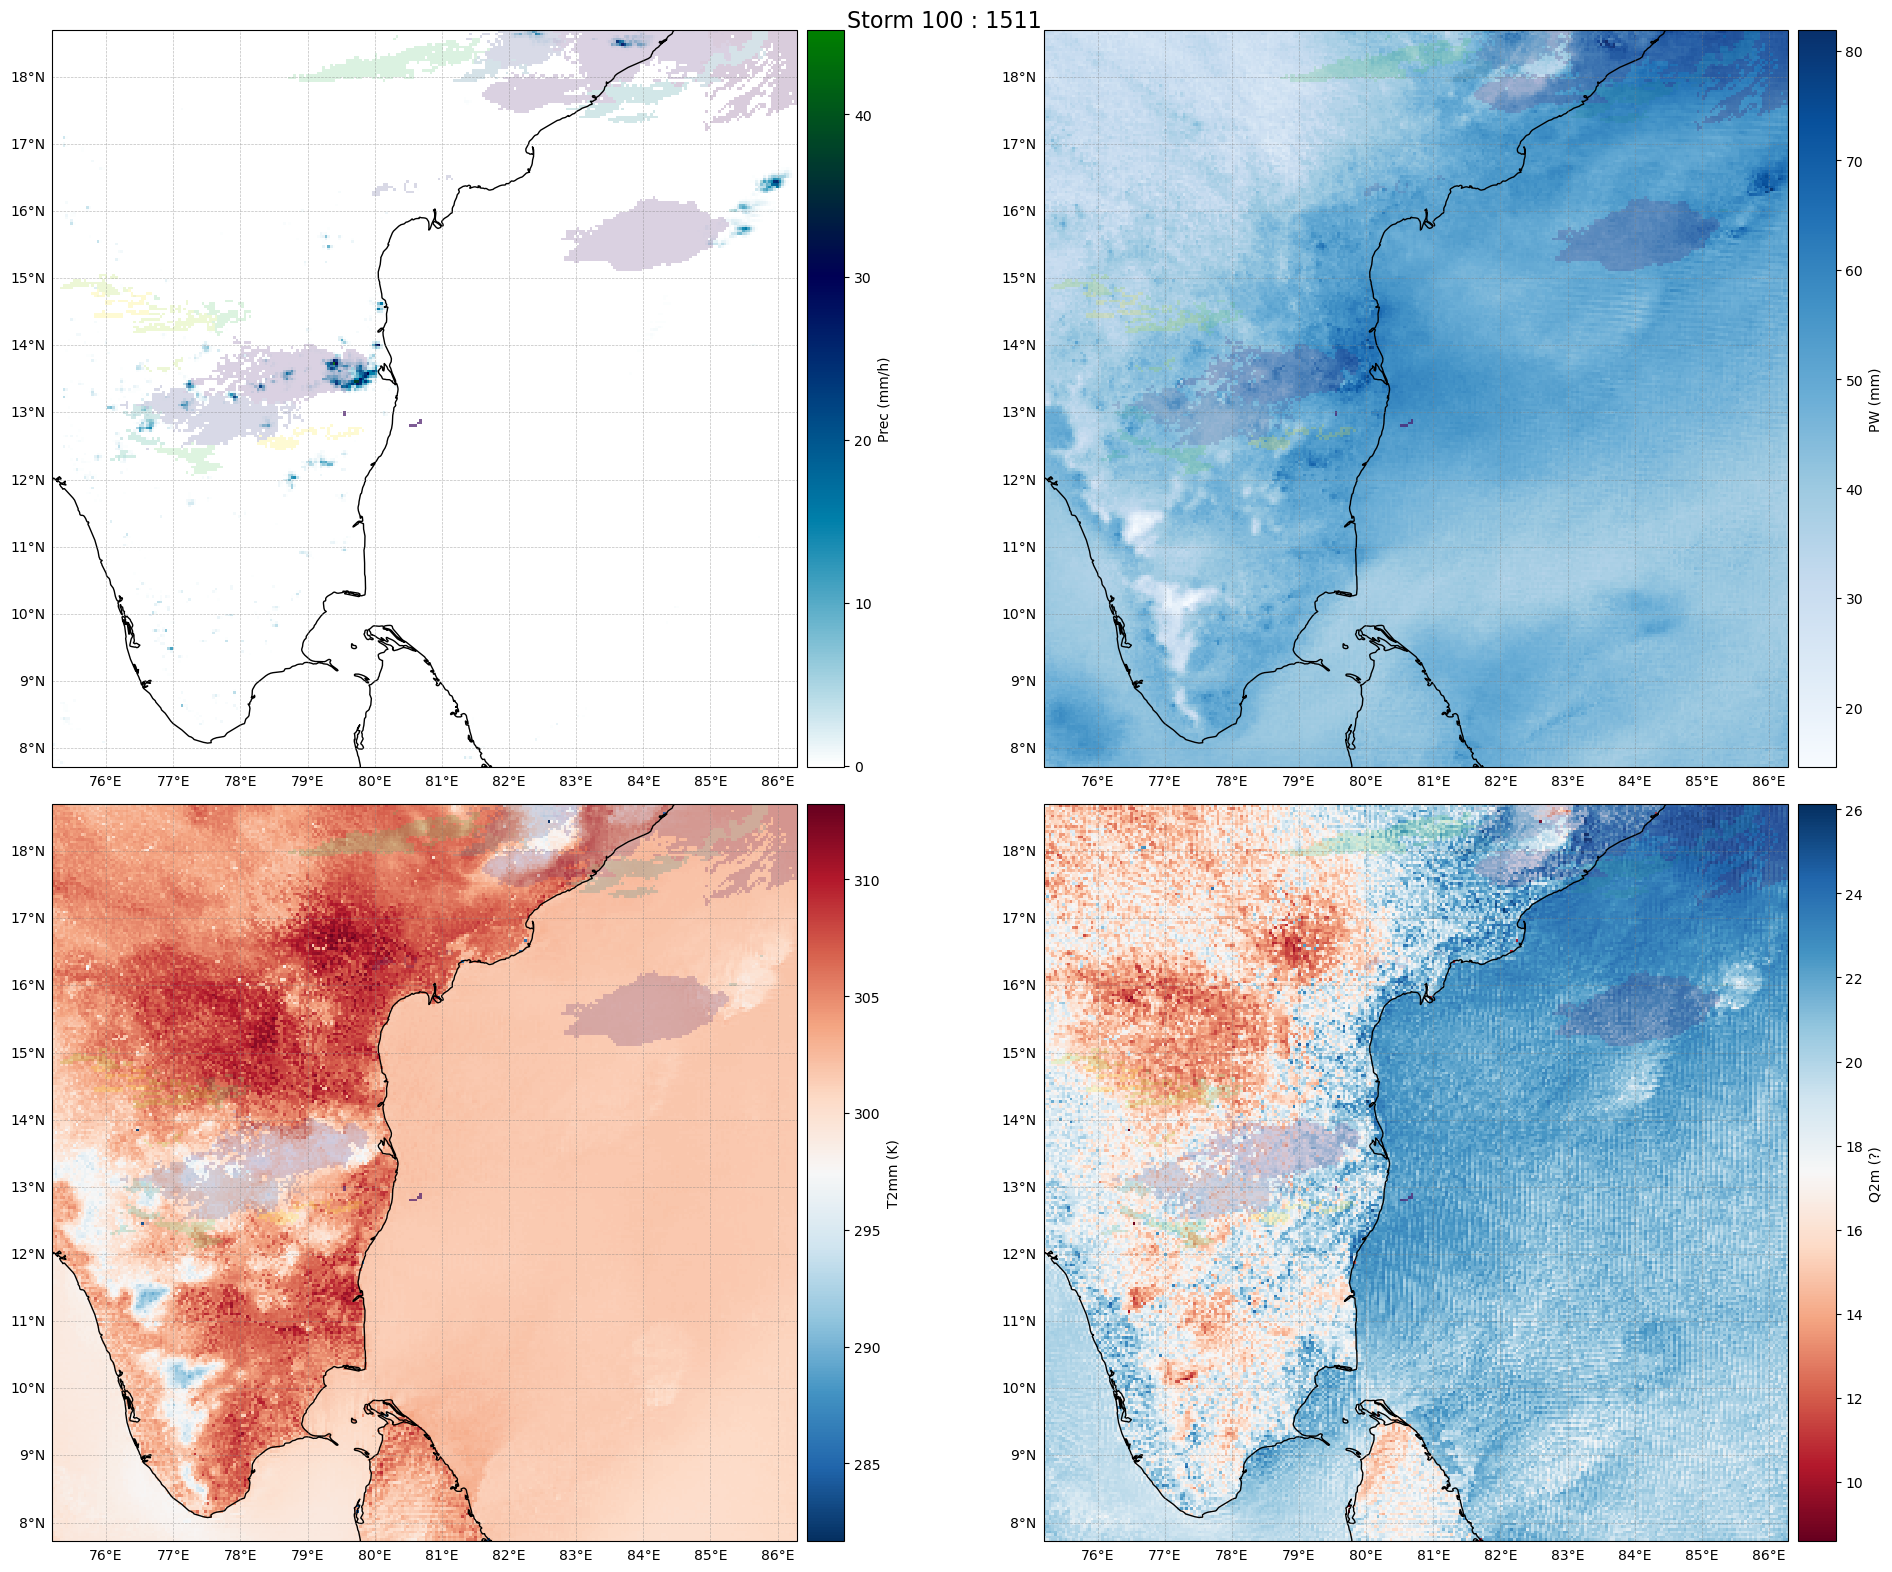

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Assuming 'seg' is your array with cloud labels
# Create a mask to identify the clouds with a specific label
cloud_mask = (seg == storm.label)

# Set alpha values for clouds based on the mask
alpha_values = np.where(cloud_mask, 0.7, 0.2)

fig, axes = plt.subplots(nrows=2, ncols=2, subplot_kw=dict(projection = ccrs.PlateCarree()), figsize=(20, 16))

# Assuming var1, var2, var3, and var4 are your different variables
var_list = vars

for ax, var, var_id, unit, cmap in zip(axes.flatten(), var_list, var_ids, var_units, var_cmaps):
    # Set latitude and longitude ticks
    v = ax.pcolormesh(seg.longitude, seg.latitude, var, cmap=cmap, shading='auto', transform=ccrs.PlateCarree())

    c = ax.pcolormesh(seg.longitude, seg.latitude, seg, transform=ccrs.PlateCarree(), cmap='viridis', alpha=alpha_values)

    ax.coastlines()

    # Adding gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    loc_interval = 1
    gl.xlocator = mticker.FixedLocator(range(-180, 181, loc_interval))
    gl.ylocator = mticker.FixedLocator(range(-90, 91, loc_interval))
    gl.top_labels = False  # Turn off labels on the top x-axis
    gl.right_labels = False  # Turn off labels on the right y-axis
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # Create colorbar in a separate axis
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1, axes_class=plt.Axes)
    label_name = f'{var_id} ({unit})'  # Use actual variable name
    cbar = plt.colorbar(v, cax=cax, orientation='vertical', label=label_name)

    # Set the projection for the colorbar axis
    # cax.set_projection(ccrs.PlateCarree())

# Adjust layout for the colorbars
fig.suptitle(f"Storm {label} : {i_t}", fontsize=16)

plt.tight_layout()
# Save the figure if needed
# plt.savefig(path_stamp)

plt.show()


In [ ]:
import matplotlib.ticker as mticker
import cartopy.crs as ccrs

verbose = False

label = 353
storm = jd.storms[label]
lifecycle = storm.clusters

utc_0, utc_f = storm.Utime_Init, storm.Utime_End
#carefull here, we remove and add 1 as to see better the conditions of genesis and dissipation
i_0, i_f = hdlr.i_t_from_utc(utc_0)-1, hdlr.i_t_from_utc(utc_f)+1

var_id = "Prec"
var_unit = "mm/h"
var_cmap = jd.settings["cmap_specs"]["prec"]

for i_t in range(i_0, i_f):
    
    length = max(storm.latmax - storm.latmin, storm.lonmax - storm.lonmin)
    bordersize = 5

    # Build the square
    if np.isclose(storm.latmax - storm.latmin, length):
        latmax, latmin = storm.latmax + bordersize, storm.latmin - bordersize
        lonmid = (storm.lonmin + storm.lonmax) / 2
        lonmax, lonmin = lonmid + bordersize + length / 2, lonmid - bordersize - length / 2
    else : 
        latmid = (storm.lonmin + storm.lonmax) / 2
        latmax, latmin = storm.latmax + bordersize + length / 2, storm.latmin - bordersize - length / 2
        lonmax, lonmin = storm.lonmax + bordersize, storm.lonmin - bordersize 
        
    if verbose : print(lonmin, lonmax, latmin, latmax)

    seg = hdlr.load_seg(i_t).sel(longitude=slice(lonmin, lonmax), latitude=slice(latmin, latmax))[0, :, :]
    n_lat, n_lon = seg.shape
    n = min(seg.shape)
    seg = seg[n_lat//2 - n//2 : n_lat//2 + n//2 , n_lon//2 - n//2 : n_lon//2 + n//2]
    
    #relative index to i_0, used to catch data from the lifecycle lists of the storm
    i = i_t - i_0 - 1 #weird because this exists only at i_0 + 1 since, at i_0 mcs ain't created
    cm_lat, cm_lon = lifecycle.lat[i], lifecycle.lon[i]

    var_ids = ["Prec", "PW", "T2mm", "Q2m"]
    var_units = ["mm/h", "mm", "K", "?"]
    var_cmaps = ["ocean_r", "Blues", "RdBu_r", "RdBu"]
    vars = []
    for var_id in var_ids:
        var = hdlr.load_var(gr, var_id, i_t)
        var = var.sel(lon=slice(lonmin, lonmax), lat=slice(latmin, latmax))[:, :] # approximate square
        var = var[n_lat//2 - n//2 : n_lat//2 + n//2 , n_lon//2 - n//2 : n_lon//2 + n//2] # exact square
        vars.append(var)
        print(f"{var_id} loaded ;", end ='\t')
    
    
        # Assuming 'seg' is your array with cloud labels
    # Create a mask to identify the clouds with a specific label
    cloud_mask = (seg == storm.label)

    # Set alpha values for clouds based on the mask
    alpha_values = np.where(cloud_mask, 0.7, 0.2)

    fig, axes = plt.subplots(nrows=2, ncols=2, subplot_kw=dict(projection = ccrs.PlateCarree()), figsize=(20, 16))

    # Assuming var1, var2, var3, and var4 are your different variables
    var_list = vars

    for ax, var, var_id, unit, cmap in zip(axes.flatten(), var_list, var_ids, var_units, var_cmaps):
        # Set latitude and longitude ticks
        v = ax.pcolormesh(seg.longitude, seg.latitude, var, cmap=cmap, shading='auto', transform=ccrs.PlateCarree())

        c = ax.pcolormesh(seg.longitude, seg.latitude, seg, transform=ccrs.PlateCarree(), cmap='viridis', alpha=alpha_values)

        ax.coastlines()

        # Adding gridlines
        gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
        loc_interval = 1
        gl.xlocator = mticker.FixedLocator(range(-180, 181, loc_interval))
        gl.ylocator = mticker.FixedLocator(range(-90, 91, loc_interval))
        gl.top_labels = False  # Turn off labels on the top x-axis
        gl.right_labels = False  # Turn off labels on the right y-axis
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')

        # Create colorbar in a separate axis
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1, axes_class=plt.Axes)
        label_name = f'{var_id} ({unit})'  # Use actual variable name
        cbar = plt.colorbar(v, cax=cax, orientation='vertical', label=label_name)

        # Set the projection for the colorbar axis
        # cax.set_projection(ccrs.PlateCarree())

    # Adjust layout for the colorbars
    fig.suptitle(f"Storm {label} : {i_t}", fontsize=16)

    plt.tight_layout()

    # saving frames and making dirs in cache
    cache = os.path.join(cs.settings["DIR_TEMPDATA"], cs.name)

    if not os.path.exists(cache):
        os.makedirs(cache)
        print("Could be made at class level")

    figname = f"storm_{label}" #maybe show a better date than it here but will do
    dir_path = os.path.join(cache, figname)

    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        print(f"made {dir_path}, don't forget to delete")

    stamp = f"{i_t}"
    path_stamp = os.path.join(dir_path, stamp)
    plt.savefig(path_stamp)
    print(f"Timestamp {i_t} saved")
    plt.close(fig)
            

In [62]:
import os
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# Output video file name
output_file = f"/home/mcarenso/code/tempest/figures/{label}.mp4"

# List all PNG files in the input directory
image_files = [file for file in os.listdir(dir_path) if file.endswith('.png')]
image_files.sort()  # Ensure sorted order

# Create a list to store image paths
image_paths = [os.path.join(dir_path, file) for file in image_files]

# Function to update the figure for each frame
def update_figure(i):
    img = plt.imread(image_paths[i])
    im.set_array(img)
    return [im]

# Create the video using Matplotlib's animation module
fig, ax = plt.subplots()
im = ax.imshow(plt.imread(image_paths[0]))

# You can customize other animation parameters such as interval, repeat, etc.
animation = animation.FuncAnimation(fig, update_figure, frames=len(image_paths), interval=500, blit=True)

animation.save(output_file, writer='ffmpeg', fps=1, dpi=300)

# Display the animation in the notebook
HTML(animation.to_jshtml())
plt.close(fig)